In [1]:
import astropy.units as u
from astropy.coordinates import SkyCoord,SphericalDifferential,ICRS,Galactic,GalacticLSR,Distance
import pandas as pd
from astropy.table import Table, join,vstack
import numpy as np
from scipy import interpolate
import math
import matplotlib
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from scipy import ndimage
from scipy.ndimage import gaussian_filter1d
import healpy as hp
from tqdm import tqdm

# Create density lines

In [2]:
dust_file = '/Users/anniegao/Documents/dustmaps_files/Dust_maps/Edenhofer_map_sketch/edenhofer_2023/gum_dust_map.fits'
f=fits.open(dust_file)
dust_map = f[0].data

In [2]:
ip= np.arange(0,196608) #np.arange(0,196608, 5)
NSIDE = 128
theta, phi = hp.pix2ang(nside=NSIDE, ipix=ip)
# center of Gum Nebula, flexible (should give the same result)
x_G = -67 #pc
y_G = -334 #pc
z_G = -65 #pc
# To pixel: 
stepsize=2 # dust map resolution
r = 350/stepsize 
xG_p = (145+x_G/stepsize) 
yG_p = (345+y_G/stepsize)
zG_p = (165+z_G/stepsize)
p_x = xG_p + r* np.sin(theta)* np.cos(phi)
p_y = yG_p + r* np.sin(theta)*np.sin(phi) 
p_z = zG_p + r* np.cos(theta)

In [3]:
loc = np.zeros((len(p_x), 3, 350))
for w in range(len(p_x)):
    loc[w, 0, :] = np.linspace(zG_p, p_z[w], 350)
    loc[w, 1, :] = np.linspace(yG_p, p_y[w], 350)
    loc[w, 2, :] = np.linspace(xG_p, p_x[w], 350)

In [10]:
def compute_column(i, loc):
    return i, ndimage.map_coordinates(dust_map, loc, order=1)

In [15]:
b = np.zeros((350, len(p_x)))
results = [compute_column(i, loc[i, :, :]) for i in tqdm(range(len(p_x)))]

100%|██████████████████████████████████| 196608/196608 [23:58<00:00, 136.66it/s]


In [16]:
density_file='/Users/anniegao/Documents/dustmaps_files/Dust_maps/Edenhofer_map_sketch/new_dustmap/density_lines_edenhofer_Gum_2_350_cut.csv'
for i, column in results:
    b[:, i] = column
pd.DataFrame(b).to_csv(density_file, index=False)

## Use density lines

data: unit [E] \
Convert to A_G using the extinction table: $A_{G} = data*2.040684938430786 [mag]$ \
Convert to column density: use relation $\frac{A_{G}}{N_{H}} = 4*10^{-22} cm^{2}*mag $ \
$N_{H} = \frac{A_{G}}{4* 10^{-22} cm^{2}* mag} = \frac{data*2.040684938430786}{4*10^{-22}} [cm^{-2}]$ \
Length of a cell: $2pc = 2*3.0857*10^{18}cm$ \
Meaning that the column density(unit: $cm^{-2}$) is in fact a volume of $V_{0}=1cm^{2}*2pc = 2*3.0857*10^{18} cm^3 $ \
volume density: $n_{H}=\frac{N_H}{V_{0}} = \frac{data*2.040684938430786}{4*10^{-22}*2*3.0857*10^{18}} [cm^{-3}] = data *826.67 [cm^{-3}]$

In [4]:
density_lines_orig = pd.read_csv(density_file)
density_lines = density_lines_orig*826.670

## Use iterative method to find Gum nebula geometry
####  <font color= '1E90FF'> So that it finds a well-defined dense dust region </font> 
The aim to start from a large smoothing factor sigma, and gradually tighten it. \
Use large smoothing factor to find the big obvious dense dust region that has a clear shape. 
And use small smoothing factor to get close to the dense region to better define its inner and outer boundary. \
Standard to stop: whether it is robust enough. Think about the definition of the boundary. Compare with history plots.

# Sketch inner boundary

In [7]:
boundary = pd.DataFrame(columns=['x[pc]', 'y[pc]', 'z[pc]', 'l[deg]', 'b[deg]', 'd[pc]','index', 'r_raw'])

In [9]:
sigma = stepsize**2/0.3 #smoothing gaussian kernel 
for p in range(density_lines.shape[1]):
    x1 = loc[p, 2, :]- xG_p
    y1 = loc[p, 1, :]- yG_p
    z1 = loc[p, 0, :]- zG_p
    dist = np.sqrt(x1**2+ y1**2+ z1**2)*stepsize
    gau_1D_dens = gaussian_filter1d(density_lines[str(p)].tolist(), sigma)
    d1 = np.gradient(gau_1D_dens, dist)
    d2 = np.gradient(d1,dist)
    pos_inflection = np.where(d1>0)
    zero_inds = np.where(np.diff(np.sign(d2))!= 0)[0]
    inf_indices = np.intersect1d(zero_inds,pos_inflection)
    try:
        inflection_i = inf_indices[0]
    except Exception:
        inflection_i = zero_inds[0]
        
    inflection_dist= dist[inflection_i]
    inf_z, inf_y, inf_x = stepsize*(loc[p, :, inflection_i]-[165,345,145]) #coordinate in the xyz frame
    galactic_lbd = SkyCoord(x = inf_x*u.pc, y = inf_y*u.pc, z = inf_z*u.pc, representation='cartesian').spherical
    boundary.loc[len(boundary)] = [inf_x, inf_y, inf_z, galactic_lbd.lon.value, galactic_lbd.lat.value, 
                               galactic_lbd.distance.value, p, inflection_dist]


In [10]:
boundary

,x[pc],y[pc],z[pc],l[deg],b[deg],d[pc],index,r_raw
0,-66.375764,-333.375764,73.392600,258.739552,12.183806,347.752233,0.0,138.395415
1,-67.624236,-333.375764,73.392600,258.533313,12.175258,347.992688,1.0,138.395415
2,-67.628760,-334.628760,74.395445,258.574374,12.293504,349.406265,2.0,139.398281
3,-66.375764,-334.624236,73.392600,258.780496,12.141373,348.949273,3.0,138.395415
4,-65.368817,-333.324342,73.384153,258.904439,12.190993,347.510335,4.0,138.395415
...,...,...,...,...,...,...,...,...
196603,-66.669035,-334.137090,-93.077944,258.716184,-15.279128,353.207954,196603.0,28.080229
196604,-66.873343,-333.873343,-93.079658,258.673786,-15.288745,352.997558,196604.0,28.080229
196605,-67.126657,-333.873343,-93.079658,258.631998,-15.286612,353.045635,196605.0,28.080229
196606,-67.126657,-334.126657,-93.079658,258.640392,-15.275994,353.285201,196606.0,28.080229


In [11]:
boundary_file = '/Users/anniegao/Documents/dustmaps_files/Dust_maps/Edenhofer_map_sketch/new_dustmap/boundary_Gum_edenhofer_center2_new_sigma_950.csv'
boundary.to_csv(boundary_file, index=False)

# Sketch outer boundary

In [28]:
boundary_out = pd.DataFrame(columns=['x[pc]', 'y[pc]', 'z[pc]', 'l[deg]', 'b[deg]', 'd[pc]','index', 'r_raw'])

In [29]:
# first derivative negative, second derivative=0
sigma = stepsize**2/0.3 #stepsize**2/2.5
for p in range(density_lines.shape[1]):
    x1 = loc[p, 2, :]- xG_p
    y1 = loc[p, 1, :]- yG_p
    z1 = loc[p, 0, :]- zG_p
    dist = np.sqrt(x1**2+ y1**2+ z1**2)*stepsize
    gau_1D_dens = gaussian_filter1d(density_lines[str(p)].tolist(), sigma)
    d1 = np.gradient(gau_1D_dens, dist)
    d2 = np.gradient(d1,dist)
    pos_inflection = np.where(d1>0)
    neg_inflection = np.where(d1<0)
    zero_inds = np.where(np.diff(np.sign(d2))!= 0)[0]
    inf_indices_pos = np.intersect1d(zero_inds, pos_inflection)
    inf_indices_neg = np.intersect1d(zero_inds, neg_inflection)
    
    if len(inf_indices_pos)>0:
        try:
            pos = np.where(zero_inds == inf_indices_pos[0])[0][0] #1st inflection
            inflection_i = zero_inds[pos+1]
            inflection_dist = dist[inflection_i]
        except Exception:
            inflection_i = np.nan
            inflection_dist = np.nan
    else:
        inflection_i= zero_inds[1]
        inflection_dist = dist[inflection_i]
    try:
        inf_z, inf_y, inf_x = stepsize*(loc[p, :, inflection_i]-[165,345,145]) 
        galactic_lbd = SkyCoord(x = inf_x*u.pc, y = inf_y*u.pc, z = inf_z*u.pc, representation='cartesian').spherical
        boundary_out.loc[len(boundary_out)] = [inf_x, inf_y, inf_z, galactic_lbd.lon.value, galactic_lbd.lat.value, 
                                               galactic_lbd.distance.value, p, inflection_dist]
    except Exception:
        boundary_out.loc[len(boundary_out)] = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, ip, np.nan]


In [30]:
outer_file = '/Users/anniegao/Documents/dustmaps_files/Dust_maps/Edenhofer_map_sketch/new_dustmap/outer_boundary_350_sigma_950.csv'
boundary_out.to_csv(outer_file, index=False)

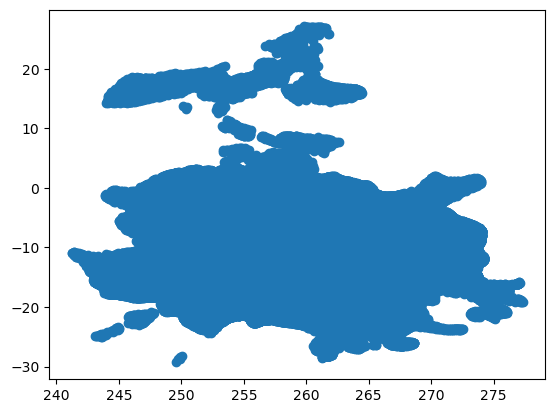

In [94]:
plt.scatter(boundary_out['l[deg]'],boundary_out['b[deg]'])